# Exploratory Analysis For Online News Popularity v2 - A Classification Problem

- by [Ayo Ayibiowu](https://www.linkedin.com/in/ayoayibiowu/)

This is a follow up of the [intiial exploratory data analysis](https://www.kaggle.com/thehapyone/exploratory-analysis-for-online-news-popularity) done for the online news populairty. In this notebook, we will using the knowledge gained so far to address a classification problem. In the [intial notebook](https://www.kaggle.com/thehapyone/exploratory-analysis-for-online-news-popularity), I attempted a popularity classification of the shares, but the model accuracy wasn't that awesome. In this notebook, I will attempt to improve that previous model accuracy, and also attempt to do some other classfication challenges. 

There will emphasize on feature selection algorthims that can be used in modelling the system for better results. Also, aside using Accuracy as the evulation metric, I will also consider some other metric evaluation.

The process followed is highlighted below:
 - Data Cleaning - Noise removal
 - Data Transformation - Transform using log-transformation
 - Data Clustering - Grouping Similar Articles together.
 - Feature Selection and Evaluation
 - Machine Learning Classification
 - Summary and Conclusion. 
 


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
# Libaries import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy
from sklearn.manifold import TSNE


## Reading the data

In [ ]:
data = pd.read_csv("/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.csv")
data.head(n=4)


# Data Processing and Noise Removal


In [ ]:
# Here we drop the two non-preditive (url and timedelta) attributes. They won't contribute anything
data.drop(labels=['url', ' timedelta'], axis = 1, inplace=True)
data.head(n=4)
# remove noise from n_tokens_content. those equals to 0
data  = data[data[' n_tokens_content'] != 0]
# Comment - Visualizing the n_non_stop_words data field shows that the present of a record with 1042 value, 
# futher observation of that data shows that it belongs to entertainment which is not actually. It belongs to world news or others.
# this particluar also contains 0 on a lot of attributes. This record is classifed as a noise and will be remove.
data = data[data[' n_non_stop_words'] != 1042]
# Here, we will go ahead and drop the field of ' n_non_stop_words. It doesn't contain relaible information.
data.drop(labels=[' n_non_stop_words'], axis = 1, inplace=True)

original_data = copy(data)


In [ ]:
# describing the data
data.describe()
# from the data, there will be need to normailze the data if their will be need for condersing any machine learning model.

In [ ]:
share_data = np.sort(data[' shares'].values)
print(share_data.shape)
leng = share_data.shape[0]

middle = share_data[int(leng*0.7)-1]
middle

In [ ]:
# ver good shares
'''
share_data = np.sort(data[' shares'].values)

leng = share_data.shape[0]

top_70 = share_data[int(leng*0.80)-1]
print (top_70)
top_50 = share_data[int(leng*0.40)-1]
print (top_50)
#temp_data = data[(data[' shares'] >= top_70)]
temp_data = data[(data[' shares'] >= top_50) & (data[' shares'] < top_70)]

print(temp_data.shape)

'''

### Create the Shares label
Two labels will be considered: Popular and Unpopular. Popular are shares above the median while unpopular are shares from median downwards

In [ ]:
# create label grades for the classes
'''
Very good = 7746 # top 80%
Good = 7785 # top 60 - top 80
Average = 8585 # 40% - 60%
Poor = 14346 # less than 40%
'''
share_label = list()
for share in data[' shares']:
    if share <= 1400:
        share_label.append('Unpopular')
    else:
        share_label.append('Popular')

# Update this class label into the dataframe
data = pd.concat([data.reset_index(drop=True), pd.DataFrame(share_label, columns=['popularity'])], axis=1)
data.head(4)

In [ ]:
# Evaluating features (sensors) contribution towards the label
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x='popularity',data=data,alpha=0.5)

data_channel_data = data.groupby('popularity').size().reset_index()
data_channel_data.columns = ['popularity','No of articles']
data_channel_data

# Data Transformation - Log Transform
The given data doesn't have a normal distribution. A log transformation will be carried out to transform the full data to have a normal distribution as close as possible

### Normal distribution analysis for Shares
Evaluating the effects of normal distribution on the shares

In [ ]:
print("Skewness: %f" % data[' shares'].skew())
print("Kurtosis: %f" % data[' shares'].kurt())

from scipy.stats import norm, probplot

#histogram and normal probability plot
temp_data = data[data[' shares'] <= 100000]
fig,ax = plt.subplots(figsize=(10,10))
sns.distplot(data[' shares'], fit=norm);
fig = plt.figure()
res = probplot(data[' shares'], plot=plt)
'''
'Shares' doesn't have a normal distribution. It shows 'peakedness', positive skewness and does not follow the diagonal line.
Thus some statistic analysis might not be suitable for it
'''

Although shares doesn't have a normal distrubition, we can do a log transformation to give us a normal distrubition data

In [ ]:
#applying log transformation
new_shares_data = copy(data)

new_shares_data.loc[new_shares_data[' shares'] > 0, ' shares'] = np.log(data.loc[data[' shares'] > 0, ' shares'])
new_shares_log = new_shares_data[' shares']
#transformed histogram and normal probability plot
fig,ax = plt.subplots(figsize=(10,10))
sns.distplot(new_shares_log, fit=norm);
fig = plt.figure()
res = probplot(new_shares_log, plot=plt)

### Finding the normal distrubution of the dataset
Transforming the whole position data to a normal distribution

In [ ]:
# use log transformation to transform each features to a normal distribution

# note log transformation can only be performed on data without zero value
for col in data.iloc[:,:-1].columns:
    #applying log transformation
    temp = data[data[col] == 0]
    # only apply to non-zero features
    if temp.shape[0] == 0:
        data[col] = np.log(data[col])
        print (col)


In [ ]:
# Evaluating the impact of log transformation

In [ ]:
# before log transformation
sns.distplot(original_data[' n_tokens_content'], fit=norm);

In [ ]:
# after log transformation
sns.distplot(data[' n_tokens_content'], fit=norm);

### Scalling The Data
A scaler that is immune to outliers needs to be used because there is a lot of outliers in the given data.

In [ ]:
# scale the data
# StandardScaler cannot guarantee balanced feature scales in the presence of outliers.
# StandardScaler removes the mean and scales the data to unit variance.
# However, the outliers have an influence when
# computing the empirical mean and standard deviation which shrink the range of the feature values 

# source: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

# Scale features using statistics that are robust to outliers.
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# scalled all the feature selections aside shares and populairty
scalled_data = scaler.fit_transform(data.iloc[:, :-2])

# update the dataframe back with the scalled data
data.iloc[:, :-2] = scalled_data

In [ ]:
# the data after log transformation and robust scaler
data.describe()

In [ ]:
data.iloc[:,:-2]

# Data Clustering - Grouping Similar Articles together.
Here, we are going to find any special pattern from the data. Using unsupervised learning to find cluster from the data and then create a new set of data out from the clusters formed. The idea is that it is easy to build a model for similar clustered articles than to build a model for all the articles.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Dimensionality reduction: PCA or t-SNE?
Which one should we used: PCA or t-SNE to transform the to a 2-dimension because k-means generally perform better on low dimension space.

In [ ]:
# Kmeans perform poorly on high feature space
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data.iloc[:,:-2])
reduced_data.shape

In [ ]:
# plotting the clusters PCA
plt.figure(figsize=(10,10))
plt.plot(reduced_data[:,0], reduced_data[:,1], 'r.')
plt.title('PCA Transformation')

plt.show()

In [ ]:
tsne = TSNE(n_components=2, n_iter=300)
reduced_tsne = tsne.fit_transform(data.iloc[:,:-2])

# plotting the clusters TSNE
plt.figure(figsize=(10,10))
plt.plot(reduced_tsne[:,0], reduced_tsne[:,1], 'r.')
plt.title('TSNE Transformation')
plt.show()

t-SNE transformation seems to make more sense that PCA transformation. We will go ahead with using t-SNE transformation

In [ ]:
k=list(range(1,9))
ssd=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(reduced_tsne)
    ssd.append(kmeans.inertia_)
    
plt.plot(k,ssd,'o-')
plt.xlabel('k')
plt.ylabel('Sum of squared error')
plt.show()

From the observation gotten so far, the higher the number of clusters the more likelihood similar articles can be grouped together.

In [ ]:
# Predicts the clusters
kmeans=KMeans(init='k-means++',n_clusters=5)
kmeans.fit(reduced_tsne)
kmeans_preds=kmeans.predict(reduced_tsne)


Plotting the cluster results

In [ ]:
centroids = kmeans.cluster_centers_
clusters = np.unique(kmeans_preds)

# ploting the result of of the clusters
ax, fig = plt.subplots(figsize=(15,7))
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

# ploting the cluster numbers
for i in range(clusters.shape[0]):
    plt.text(centroids[i, 0], centroids[i, 1], clusters[i], fontsize=20, color='white', 
             bbox=dict(facecolor='black', alpha=0.5))
    
plt.scatter(reduced_tsne[:,0],reduced_tsne[:,1],c=kmeans_preds,marker='.')
plt.show()

In [ ]:
# fussing the cluster data into the dataframe
data1=pd.concat([data.reset_index(drop=True), pd.DataFrame(kmeans_preds, columns=['clusters'])],axis=1)

In [ ]:
data1.shape

In [ ]:
# extrating individual cluster from the data
cluster1_data = data1[data1['clusters'] == 0]
cluster2_data = data1[data1['clusters'] == 1]
cluster3_data = data1[data1['clusters'] == 2]
cluster4_data = data1[data1['clusters'] == 3]
cluster5_data = data1[data1['clusters'] == 4]
print ('Cluster1 size: ',cluster1_data.shape)
print ('Cluster2 size: ',cluster2_data.shape)
print ('Cluster3 size: ',cluster3_data.shape)
print ('Cluster4 size: ',cluster4_data.shape)
print ('Cluster5 size: ',cluster5_data.shape)

# Feature Selection and Feature Extraction
We will performe a couple of feature selections and also feature extraction on the data clusters. The reults of the feature selections will be used to as input to a machine learning classfication model to predict the popularity of the article. The below feature selections and extraction were considered:
* Mutual Information
* F-Score
* Recursive Feature Elimination
* PCA (Principal Component Analysis)
* KPCA (Kernel PCA) - It was later removed, wasn't improving the model, time and memory consuming 
* MDS (Manifold Sculpting) - It was later removed, wasn't improving the model, time and memory consuming 
* T-SNE - It was later removed, wasn't improving the model, time and memory consuming 


### Mutual Information
Mutual information can find relations between two random variables. It can observe both the linear and unlinear relationship. If the mutual information between 2 variables is 0, then according to mutual information, those 2 variables doesn't have any relationship.

In [ ]:
# Mutual Information computation
# our label is the popularity and will be disregarding the shares data
from sklearn.feature_selection import mutual_info_classif

# Mutual information for cluster 1
X1 = cluster1_data.iloc[:, :-3]
y1 = cluster1_data.iloc[:, -2]
mi_data_clus1 = mutual_info_classif(X1, y1, 'auto')

In [ ]:
# mututal information for cluster 2
X2 = cluster2_data.iloc[:, :-3]
y2 = cluster2_data.iloc[:, -2]
mi_data_clus2 = mutual_info_classif(X2, y2, 'auto')

In [ ]:
# mututal information for cluster 3
X3 = cluster3_data.iloc[:, :-3]
y3 = cluster3_data.iloc[:, -2]
mi_data_clus3 = mutual_info_classif(X3, y3, 'auto')
# mututal information for cluster 3
X4 = cluster4_data.iloc[:, :-3]
y4 = cluster4_data.iloc[:, -2]
mi_data_clus4 = mutual_info_classif(X4, y4, 'auto')
# mututal information for cluster 3
X5 = cluster5_data.iloc[:, :-3]
y5 = cluster5_data.iloc[:, -2]
mi_data_clus5 = mutual_info_classif(X5, y5, 'auto')

In [ ]:
# ploting the result of mutual information
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X1.columns,y=mi_data_clus1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Mutual Information for all Features - Cluster 1")

In [ ]:
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X2.columns,y=mi_data_clus2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Mutual Information for all Features - Cluster 2")

In [ ]:
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X3.columns,y=mi_data_clus3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Mutual Information for all Features - Cluster 3")

In [ ]:
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X4.columns,y=mi_data_clus4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Mutual Information for all Features - Cluster 4")

In [ ]:
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X5.columns,y=mi_data_clus5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Mutual Information for all Features - Cluster 5")

In [ ]:
### an helper function for extracting the best features possible
def extract_best_features(feature_scores, feature_col, n=5, sort_metric=False):
    # this function extracts out the best features.
    # inputs 
    temp = np.hstack((feature_scores.reshape(-1,1), feature_col.reshape(-1,1)))
    features = pd.DataFrame(temp, columns=['score', 'name'])
    # sort the features
    features = features.sort_values(by=['score'], ascending=sort_metric).reset_index(drop=True)
    # extract the best features
    best_features = features.iloc[:n, :].to_numpy()
    return best_features


In [ ]:
best_features = extract_best_features(mi_data_clus4, X4.columns.values, n=10)
best_features


### F-Score

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
# F-Score for cluster 1

f_test_data = f_classif(X1, y1)
f_score_1=f_test_data[0]

plt.figure(figsize=(15, 5))
g = sns.barplot(x=X1.columns,y=f_score_1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 1")

In [ ]:
# F-Score for cluster 2
f_test_data = f_classif(X2, y2)
f_score_2=f_test_data[0]

plt.figure(figsize=(15, 5))
g = sns.barplot(x=X2.columns,y=f_score_2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 2")

In [ ]:
# F-Score for cluster 3
f_test_data = f_classif(X3, y3)
f_score_3=f_test_data[0]

plt.figure(figsize=(15, 5))
g = sns.barplot(x=X3.columns,y=f_score_3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 3")

In [ ]:
# F-Score for cluster 4
f_test_data = f_classif(X4, y4)
f_score_4=f_test_data[0]

# F-Score for cluster 5
f_test_data = f_classif(X5, y5)
f_score_5=f_test_data[0]


In [ ]:
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X4.columns,y=f_score_4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 4")

In [ ]:
plt.figure(figsize=(15, 5))
g = sns.barplot(x=X4.columns,y=f_score_5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 5")

In [ ]:
best_features = extract_best_features(f_score_1, X1.columns.values, n=10)
best_features

### Recursive Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Random forest is used as the model for RFE
# RFE for Cluster 1
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
# for 5 features
rfe = RFE(model, 5) 
rfe = rfe.fit(X1, y1)
rfe_5_features_clus1 = X1.columns.values[rfe.get_support()]
# for 10 features
rfe = RFE(model, 10) 
rfe = rfe.fit(X1, y1)
rfe_10_features_clus1 = X1.columns.values[rfe.get_support()]
# for 20 features
rfe = RFE(model, 20) 
rfe = rfe.fit(X1, y1)
rfe_20_features_clus1  = X1.columns.values[rfe.get_support()]
# for 30 features
rfe = RFE(model, 30) 
rfe = rfe.fit(X1, y1)
rfe_30_features_clus1 = X1.columns.values[rfe.get_support()]

In [ ]:
# Random forest is used as the model for RFE
# RFE for Cluster 2
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
# for 5 features
rfe = RFE(model, 5) 
rfe = rfe.fit(X2, y2)
rfe_5_features_clus2 = X2.columns.values[rfe.get_support()]
# for 10 features
rfe = RFE(model, 10) 
rfe = rfe.fit(X2, y2)
rfe_10_features_clus2 = X2.columns.values[rfe.get_support()]
# for 20 features
rfe = RFE(model, 20) 
rfe = rfe.fit(X2, y2)
rfe_20_features_clus2  = X2.columns.values[rfe.get_support()]
# for 30 features
rfe = RFE(model, 30) 
rfe = rfe.fit(X2, y2)
rfe_30_features_clus2 = X2.columns.values[rfe.get_support()]

In [ ]:
# Random forest is used as the model for RFE
# RFE for Cluster 3
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
# for 5 features
rfe = RFE(model, 5) 
rfe = rfe.fit(X3, y3)
rfe_5_features_clus3 = X3.columns.values[rfe.get_support()]
# for 10 features
rfe = RFE(model, 10) 
rfe = rfe.fit(X3, y3)
rfe_10_features_clus3 = X3.columns.values[rfe.get_support()]
# for 20 features
rfe = RFE(model, 20) 
rfe = rfe.fit(X3, y3)
rfe_20_features_clus3  = X3.columns.values[rfe.get_support()]
# for 30 features
rfe = RFE(model, 30) 
rfe = rfe.fit(X3, y3)
rfe_30_features_clus3 = X3.columns.values[rfe.get_support()]

In [ ]:
# Random forest is used as the model for RFE
# RFE for Cluster 4
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
# for 5 features
rfe = RFE(model, 5) 
rfe = rfe.fit(X4, y4)
rfe_5_features_clus4 = X4.columns.values[rfe.get_support()]
# for 10 features
rfe = RFE(model, 10) 
rfe = rfe.fit(X4, y4)
rfe_10_features_clus4 = X4.columns.values[rfe.get_support()]
# for 20 features
rfe = RFE(model, 20) 
rfe = rfe.fit(X4, y4)
rfe_20_features_clus4  = X4.columns.values[rfe.get_support()]
# for 30 features
rfe = RFE(model, 30) 
rfe = rfe.fit(X4, y4)
rfe_30_features_clus4 = X4.columns.values[rfe.get_support()]

In [ ]:
# Random forest is used as the model for RFE
# RFE for Cluster 5
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
# for 5 features
rfe = RFE(model, 5) 
rfe = rfe.fit(X5, y5)
rfe_5_features_clus5 = X5.columns.values[rfe.get_support()]
# for 10 features
rfe = RFE(model, 10) 
rfe = rfe.fit(X5, y5)
rfe_10_features_clus5 = X5.columns.values[rfe.get_support()]
# for 20 features
rfe = RFE(model, 20) 
rfe = rfe.fit(X5, y5)
rfe_20_features_clus5  = X5.columns.values[rfe.get_support()]
# for 30 features
rfe = RFE(model, 30) 
rfe = rfe.fit(X5, y5)
rfe_30_features_clus5 = X5.columns.values[rfe.get_support()]

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#########################################################
# PCA for cluster 1
# for 5 features
transformer = PCA(n_components=5)
pca_clus1_5 = transformer.fit_transform(X1)
# for 10 features
transformer = PCA(n_components=10)
pca_clus1_10 = transformer.fit_transform(X1)
# for 20 features
transformer = PCA(n_components=20)
pca_clus1_20 = transformer.fit_transform(X1)
# for 30 features
transformer = PCA(n_components=30)
pca_clus1_30 = transformer.fit_transform(X1)

In [ ]:
# PCA for cluster 2
# for 5 features
transformer = PCA(n_components=5)
pca_clus2_5 = transformer.fit_transform(X2)
# for 10 features
transformer = PCA(n_components=10)
pca_clus2_10 = transformer.fit_transform(X2)
# for 20 features
transformer = PCA(n_components=20)
pca_clus2_20 = transformer.fit_transform(X2)
# for 30 features
transformer = PCA(n_components=30)
pca_clus2_30 = transformer.fit_transform(X2)

In [ ]:
# PCA for cluster 3
# for 5 features
transformer = PCA(n_components=5)
pca_clus3_5 = transformer.fit_transform(X3)
# for 10 features
transformer = PCA(n_components=10)
pca_clus3_10 = transformer.fit_transform(X3)
# for 20 features
transformer = PCA(n_components=20)
pca_clus3_20 = transformer.fit_transform(X3)
# for 30 features
transformer = PCA(n_components=30)
pca_clus3_30 = transformer.fit_transform(X3)

In [ ]:
# PCA for cluster 4
# for 5 features
transformer = PCA(n_components=5)
pca_clus4_5 = transformer.fit_transform(X4)
# for 10 features
transformer = PCA(n_components=10)
pca_clus4_10 = transformer.fit_transform(X4)
# for 20 features
transformer = PCA(n_components=20)
pca_clus4_20 = transformer.fit_transform(X4)
# for 30 features
transformer = PCA(n_components=30)
pca_clus4_30 = transformer.fit_transform(X4)

In [ ]:
# PCA for cluster 5
# for 5 features
transformer = PCA(n_components=5)
pca_clus5_5 = transformer.fit_transform(X5)
# for 10 features
transformer = PCA(n_components=10)
pca_clus5_10 = transformer.fit_transform(X5)
# for 20 features
transformer = PCA(n_components=20)
pca_clus5_20 = transformer.fit_transform(X5)
# for 30 features
transformer = PCA(n_components=30)
pca_clus5_30 = transformer.fit_transform(X5)

# Classification Problem
Now, we will use the results of our feature selections and extraction for classification of the shares and data channel
3 Machine learning models will be considered:
 - KNN
 - SVC
 - Random Forest

## Classification of Article Popularity

In [ ]:
# encoding the label set with a label encoder
from sklearn.preprocessing import LabelEncoder

labelEn = LabelEncoder()
encoded_labels = labelEn.fit_transform(y1.values)
class_names = labelEn.classes_
class_names

In [ ]:
# Splitting the data for Training and Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import recall_score

### KNN


In [ ]:
#### PCA Features

In [ ]:
# defining the model
from sklearn.neighbors import KNeighborsClassifier

# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

pca_data = [pca_clus1_5, pca_clus1_10, pca_clus1_20, pca_clus1_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 1::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
    
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

pca_data = [pca_clus2_5, pca_clus2_10, pca_clus2_20, pca_clus2_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 2::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)

pca_data = [pca_clus3_5, pca_clus3_10, pca_clus3_20, pca_clus3_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 3::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
    
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)

pca_data = [pca_clus4_5, pca_clus4_10, pca_clus4_20, pca_clus4_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 4::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)

pca_data = [pca_clus5_5, pca_clus5_10, pca_clus5_20, pca_clus5_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 5::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      

In [ ]:
#### KNN Cross-Validation

In [ ]:
import matplotlib.pyplot as plt

##############################################################
# Cros Validation for any of the features
k_range = np.arange(1,120)
accuracy = []

for n in k_range:    
    neigh = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    #print ("Random Forest Classifer Result")
    #print ("Performance - " + str(100*accuracy_score(y_pred, y_test_2)) + "%")
    accuracy.append(100*accuracy_score(y_pred, y_test))



plt.figure(figsize=(20,13))
plt.plot(k_range, accuracy, 'r-', label='KNN Accuracy Vs KNN Neighbors size')
plt.plot(k_range, accuracy, 'bx')
plt.xlabel('KNN Neighbors size')
plt.ylabel('KNN Accuracy')
plt.legend()
plt.grid()
plt.title('KNN Accuracy Vs Neighbors size')
plt.show()

#### Mutual Information

In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)


features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus1, X1.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(best_features[:,1]))
    data_clus_mi = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 1::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus2, X2.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(best_features[:,1]))
    data_clus_mi = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 2::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus3, X3.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(best_features[:,1]))
    data_clus_mi = X3.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 3::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      

# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus4, X4.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(best_features[:,1]))
    data_clus_mi = X4.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 4::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus5, X5.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(best_features[:,1]))
    data_clus_mi = X5.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 5::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      

#### F-Score

In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_1, X1.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(best_features[:,1]))
    data_clus_mi = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 1::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_2, X2.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(best_features[:,1]))
    data_clus_mi = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 2::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_3, X3.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(best_features[:,1]))
    data_clus_mi = X3.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 3::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_4, X4.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(best_features[:,1]))
    data_clus_mi = X4.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 4::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_5, X5.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(best_features[:,1]))
    data_clus_mi = X5.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 5::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  

#### RFE

In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

rfe_features_clus1 = [rfe_5_features_clus1, rfe_10_features_clus1, rfe_20_features_clus1, rfe_30_features_clus1]

for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(rfe_features_clus1[i]))
    data_clus_rfe = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 1::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
rfe_features_clus2 = [rfe_5_features_clus2, rfe_10_features_clus2, rfe_20_features_clus2, rfe_30_features_clus2]

for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(rfe_features_clus2[i]))
    data_clus_rfe = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 2::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)
rfe_features_clus3 = [rfe_5_features_clus3, rfe_10_features_clus3, rfe_20_features_clus3, rfe_30_features_clus3]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(rfe_features_clus3[i]))
    data_clus_rfe = X3.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 3::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)
rfe_features_clus4 = [rfe_5_features_clus4, rfe_10_features_clus4, rfe_20_features_clus4, rfe_30_features_clus4]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(rfe_features_clus4[i]))
    data_clus_rfe = X4.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 4::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)
rfe_features_clus5 = [rfe_5_features_clus5, rfe_10_features_clus5, rfe_20_features_clus5, rfe_30_features_clus5]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(rfe_features_clus5[i]))
    data_clus_rfe = X5.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 3::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      

### Random Forest

In [ ]:
#### PCA

In [ ]:
# defining the model
from sklearn.neighbors import KNeighborsClassifier

# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

pca_data = [pca_clus1_5, pca_clus1_10, pca_clus1_20, pca_clus1_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']


for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 1::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

pca_data = [pca_clus2_5, pca_clus2_10, pca_clus2_20, pca_clus2_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.3, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 2::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)

pca_data = [pca_clus3_5, pca_clus3_10, pca_clus3_20, pca_clus3_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.3, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 3::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)

pca_data = [pca_clus4_5, pca_clus4_10, pca_clus4_20, pca_clus4_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.3, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 4::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
   
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)

pca_data = [pca_clus5_5, pca_clus5_10, pca_clus5_20, pca_clus5_30]
features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(pca_data)):
    # For PCA Feature Extraction
    X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.3, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 5::PCA - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
   

#### Mutual Information

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus1, X1.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(best_features[:,1]))
    data_clus_mi = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=1000, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 1::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus2, X2.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(best_features[:,1]))
    data_clus_mi = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=1000, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 2::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus3, X3.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(best_features[:,1]))
    data_clus_mi = X3.drop(drop_these, axis=1, inplace=False)
    clf = RandomForestClassifier(n_estimators=1000, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 3::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus4, X4.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(best_features[:,1]))
    data_clus_mi = X4.drop(drop_these, axis=1, inplace=False)
    clf = RandomForestClassifier(n_estimators=1000, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 4::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(mi_data_clus5, X5.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(best_features[:,1]))
    data_clus_mi = X5.drop(drop_these, axis=1, inplace=False)
    clf = RandomForestClassifier(n_estimators=1000, n_jobs=5, max_depth=100,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 5::MI - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
     

In [ ]:
#### Cross validation For Random Forest

nns = [1, 5, 10, 50, 100, 200, 500, 1000, 2000, 3000]
accuracy = []

for n in nns:    
    clf = RandomForestClassifier(n_estimators=n, n_jobs=5, max_depth=500,
                                 random_state=0)
    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    #print ("Random Forest Classifer Result")
    #print ("Performance - " + str(100*accuracy_score(y_pred, y_test_2)) + "%")
    accuracy.append(100*accuracy_score(y_pred, y_test))

    
plt.figure(figsize=(10,7))
plt.plot(nns, accuracy, 'r-', label='Random Forest Accuracy Vs Number of Tress')
plt.plot(nns, accuracy, 'bx')
plt.xlabel('Random Forest Tree Sizes')
plt.ylabel('Random Forest Accuracy')
plt.legend()
plt.grid()
plt.title('Random Forest Accuracy Vs Number of Tress')
plt.show()

#### F-Score

In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_1, X1.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(best_features[:,1]))
    data_clus_mi = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 1::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_2, X2.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(best_features[:,1]))
    data_clus_mi = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 2::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_3, X3.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(best_features[:,1]))
    data_clus_mi = X3.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 3::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
    
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_4, X4.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(best_features[:,1]))
    data_clus_mi = X4.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 4::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
    
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_5, X5.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(best_features[:,1]))
    data_clus_mi = X5.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 5::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  

#### RFE

In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

rfe_features_clus1 = [rfe_5_features_clus1, rfe_10_features_clus1, rfe_20_features_clus1, rfe_30_features_clus1]

for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(rfe_features_clus1[i]))
    data_clus_rfe = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 1::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
rfe_features_clus2 = [rfe_5_features_clus2, rfe_10_features_clus2, rfe_20_features_clus2, rfe_30_features_clus2]

for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(rfe_features_clus2[i]))
    data_clus_rfe = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 2::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)
rfe_features_clus3 = [rfe_5_features_clus3, rfe_10_features_clus3, rfe_20_features_clus3, rfe_30_features_clus3]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(rfe_features_clus3[i]))
    data_clus_rfe = X3.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 3::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
     
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)
rfe_features_clus4 = [rfe_5_features_clus4, rfe_10_features_clus4, rfe_20_features_clus4, rfe_30_features_clus4]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(rfe_features_clus4[i]))
    data_clus_rfe = X4.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 4::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
     
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)
rfe_features_clus5 = [rfe_5_features_clus5, rfe_10_features_clus5, rfe_20_features_clus5, rfe_30_features_clus5]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(rfe_features_clus5[i]))
    data_clus_rfe = X5.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 5::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
     

### SVM

In [ ]:
#### RFE
from sklearn.svm import SVC


In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

rfe_features_clus1 = [rfe_5_features_clus1, rfe_10_features_clus1, rfe_20_features_clus1, rfe_30_features_clus1]

for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X1.columns.values) - set(rfe_features_clus1[i]))
    data_clus_rfe = X1.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = SVC(gamma='auto')

    # commence training - NOTE: It takes hours to be complete
    clf.fit(X_train, y_train) 

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 1::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
  
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
rfe_features_clus2 = [rfe_5_features_clus2, rfe_10_features_clus2, rfe_20_features_clus2, rfe_30_features_clus2]

for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X2.columns.values) - set(rfe_features_clus2[i]))
    data_clus_rfe = X2.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = SVC(gamma='auto')

    # commence training - NOTE: It takes hours to be complete
    clf.fit(X_train, y_train) 

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 2::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
  
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3.values)
rfe_features_clus3 = [rfe_5_features_clus3, rfe_10_features_clus3, rfe_20_features_clus3, rfe_30_features_clus3]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X3.columns.values) - set(rfe_features_clus3[i]))
    data_clus_rfe = X3.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = SVC(gamma='auto')

    # commence training - NOTE: It takes hours to be complete
    clf.fit(X_train, y_train) 

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 3::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
     
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4.values)
rfe_features_clus4 = [rfe_5_features_clus4, rfe_10_features_clus4, rfe_20_features_clus4, rfe_30_features_clus4]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X4.columns.values) - set(rfe_features_clus4[i]))
    data_clus_rfe = X4.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = SVC(gamma='auto')

    # commence training - NOTE: It takes hours to be complete
    clf.fit(X_train, y_train) 

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 4::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
     
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5.values)
rfe_features_clus5 = [rfe_5_features_clus5, rfe_10_features_clus5, rfe_20_features_clus5, rfe_30_features_clus5]

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    # the feautures are stored in the seconds column
    drop_these = list(set(X5.columns.values) - set(rfe_features_clus5[i]))
    data_clus_rfe = X5.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_rfe, encoded_labels, test_size=0.2, shuffle=False)

    clf = SVC(gamma='auto')

    # commence training - NOTE: It takes hours to be complete
    clf.fit(X_train, y_train) 

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 5::RFE - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")


## Classification of Data Channel.
For this challenge, F-score will only be used as the form of feature selection methods.

In [ ]:
# Classification of the Data Channel an article was presented 

In [ ]:
data_weekdays = copy(data.iloc[:, :-1])
data_weekdays

In [ ]:
# combine the data_channels as one

# Merging the data channels as one single column
DataChannelMerge=data[[' data_channel_is_lifestyle',' data_channel_is_entertainment' ,' data_channel_is_bus',
                        ' data_channel_is_socmed' ,' data_channel_is_tech',' data_channel_is_world' ]]
#logic to merge data channel
DataChannel_arr=[]
for r in list(range(DataChannelMerge.shape[0])):
    if (((DataChannelMerge.iloc[r,0])==0) and ((DataChannelMerge.iloc[r,1])==0) and ((DataChannelMerge.iloc[r,2])==0) and ((DataChannelMerge.iloc[r,3])==0) and ((DataChannelMerge.iloc[r,4])==0) and ((DataChannelMerge.iloc[r,5])==0)):
        DataChannel_arr.append('Others')
    for c in list(range(DataChannelMerge.shape[1])):
        if ((c==0) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Lifestyle')
        elif ((c==1) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Entertainment')
        elif ((c==2) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Business')
        elif ((c==3) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Social Media')
        elif ((c==4) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Tech')
        elif ((c==5) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('World')


In [ ]:
# merge the the new data into the dataframe
data_weekdays.insert(loc=58, column='channels', value=DataChannel_arr)

# Now I drop the old data
data_weekdays.drop(labels=[' data_channel_is_lifestyle',' data_channel_is_entertainment' ,' data_channel_is_bus',
                        ' data_channel_is_socmed' ,' data_channel_is_tech',' data_channel_is_world'], axis = 1, inplace=True)
print(data_weekdays.shape)
data_weekdays.head(n=4)

### Here we check the class balance


In [ ]:
# Evaluating features (sensors) contribution towards the label
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x='channels',data=data_weekdays,alpha=0.5)


In [ ]:
# Fetch the counts for each class
class_counts = data_weekdays.groupby('channels').size().reset_index()
class_counts.columns = ['channels','No of articles']
class_counts


In [ ]:
# transform the data

encoded_labels = labelEn.fit_transform(data_weekdays.loc[:, 'channels'].values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

# the feautures are stored in the seconds column
X_train, X_test, y_train, y_test = train_test_split(data_weekdays.iloc[:, :-1], encoded_labels, test_size=0.2, shuffle=False)

clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                             random_state=0)

clf.fit(X_train, y_train)  

# predict the result
y_pred = clf.predict(X_test)
print ("Random Forest - ::Full - ")
print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))

In [ ]:
tsne = TSNE(n_components=2, n_iter=300)
reduced_tsne = tsne.fit_transform(data_weekdays.iloc[:,:-1])

# plotting the clusters TSNE
plt.figure(figsize=(10,10))
plt.plot(reduced_tsne[:,0], reduced_tsne[:,1], 'r.')
plt.title('TSNE Transformation')
plt.show()

In [ ]:
# Predicts the clusters
kmeans=KMeans(init='k-means++',n_clusters=5)
kmeans.fit(reduced_tsne)
kmeans_preds=kmeans.predict(reduced_tsne)


In [ ]:
# fussing the cluster data into the dataframe
data_weekdays2=pd.concat([data_weekdays.reset_index(drop=True), pd.DataFrame(kmeans_preds, columns=['clusters'])],axis=1)

In [ ]:
# extrating individual cluster from the data
cluster1_data_weekdays = data_weekdays2[data_weekdays2['clusters'] == 0]
cluster2_data_weekdays = data_weekdays2[data_weekdays2['clusters'] == 1]
cluster3_data_weekdays = data_weekdays2[data_weekdays2['clusters'] == 2]
cluster4_data_weekdays = data_weekdays2[data_weekdays2['clusters'] == 3]
cluster5_data_weekdays = data_weekdays2[data_weekdays2['clusters'] == 4]
print ('Cluster1 size: ',cluster1_data_weekdays.shape)
print ('Cluster2 size: ',cluster2_data_weekdays.shape)
print ('Cluster3 size: ',cluster3_data_weekdays.shape)
print ('Cluster4 size: ',cluster4_data_weekdays.shape)
print ('Cluster5 size: ',cluster5_data_weekdays.shape)

In [ ]:
### F- score

# mututal information for cluster 3
X1_week = cluster1_data_weekdays.iloc[:, :-2]
y1_week = cluster1_data_weekdays.iloc[:, -2]

# mututal information for cluster 3
X2_week = cluster2_data_weekdays.iloc[:, :-2]
y2_week = cluster2_data_weekdays.iloc[:, -2]

# mututal information for cluster 3
X3_week = cluster3_data_weekdays.iloc[:, :-2]
y3_week = cluster3_data_weekdays.iloc[:, -2]

# mututal information for cluster 3
X4_week = cluster4_data_weekdays.iloc[:, :-2]
y4_week = cluster4_data_weekdays.iloc[:, -2]

# mututal information for cluster 3
X5_week = cluster5_data_weekdays.iloc[:, :-2]
y5_week = cluster5_data_weekdays.iloc[:, -2]



# F-Score for cluster 1
f_test_data = f_classif(X1_week, y1_week)
f_score_1_wk=f_test_data[0]

# F-Score for cluster 5
f_test_data = f_classif(X2_week, y2_week)
f_score_2_wk=f_test_data[0]

# F-Score for cluster 5
f_test_data = f_classif(X3_week, y3_week)
f_score_3_wk=f_test_data[0]

# F-Score for cluster 4
f_test_data = f_classif(X4_week, y4_week)
f_score_4_wk=f_test_data[0]

# F-Score for cluster 5
f_test_data = f_classif(X5_week, y5_week)
f_score_5_wk=f_test_data[0]


### KNN

In [ ]:
# For Cluster 1
encoded_labels = labelEn.fit_transform(y1_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_1_wk, X1_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X1_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X1_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 1::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_2_wk, X2_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X2_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X2_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 2::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_3_wk, X3_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X3_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X3_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 3::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_4_wk, X4_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X4_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X4_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 4::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_5_wk, X5_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X5_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X5_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    neigh = KNeighborsClassifier(n_neighbors=63, n_jobs=-1)

    neigh.fit(X_train, y_train)  

    # predict the result
    y_pred = neigh.predict(X_test)
    print ("KNN - Cluster 5::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='micro')))
  

In [ ]:
### Random forest

# For Cluster 1
encoded_labels = labelEn.fit_transform(y1_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
n_features = [5, 10, 20, 30]

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_1_wk, X1_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X1_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X1_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 1::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='weighted')))
      
# For Cluster 2
encoded_labels = labelEn.fit_transform(y2_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']

for i in range(len(features_list)):
    best_features = extract_best_features(f_score_2_wk, X2_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X2_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X2_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 2::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='weighted')))
      
# For Cluster 3
encoded_labels = labelEn.fit_transform(y3_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_3_wk, X3_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X3_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X3_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 3::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='weighted')))
  
    
# For Cluster 4
encoded_labels = labelEn.fit_transform(y4_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_4_wk, X4_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X4_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X4_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 4::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='weighted')))
  
    
# For Cluster 5
encoded_labels = labelEn.fit_transform(y5_week.values)

features_list = ['5 Features', '10 Features', '20 Features', '30 Features']
for i in range(len(features_list)):
    best_features = extract_best_features(f_score_5_wk, X5_week.columns.values, n=n_features[i])
    # the feautures are stored in the seconds column
    drop_these = list(set(X5_week.columns.values) - set(best_features[:,1]))
    data_clus_mi = X5_week.drop(drop_these, axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(data_clus_mi, encoded_labels, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier(n_estimators=500, n_jobs=5, max_depth=50,
                                 random_state=0)

    clf.fit(X_train, y_train)  

    # predict the result
    y_pred = clf.predict(X_test)
    print ("Random Forest - Cluster 5::F-score - " + str(features_list[i]))
    print ("Accuracy - " + str(100*accuracy_score(y_pred, y_test)) + "%")
    print ("Recall - " + str(recall_score(y_test, y_pred, average='weighted')))
  

# Results
In the classification task, we applied 3 machine learning models on the clusters obtained from the cluster extraction with four feature space namely top 5, top 10, top 20 and top 30 features from all feature selection methods: mutual information, f-score, RFE and PCA. Accuracy and recall were used as the main evaluation criteria for this task.

For Popularity results, the overal cluster results is presented below:

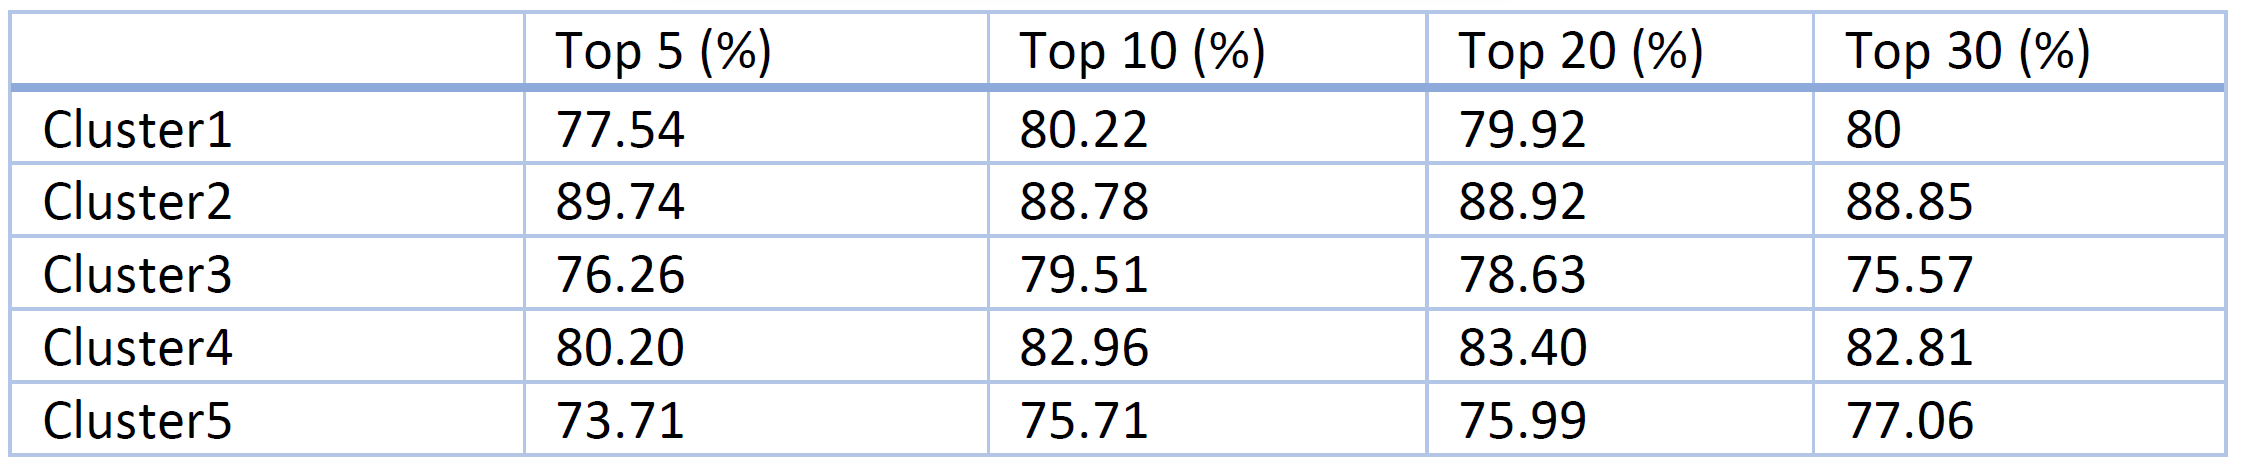

Random Forest generally performed the best and their wasn't much signficant difference between all the feature selection considered.

For data channel prediciton, the overal cluster results is shown below:
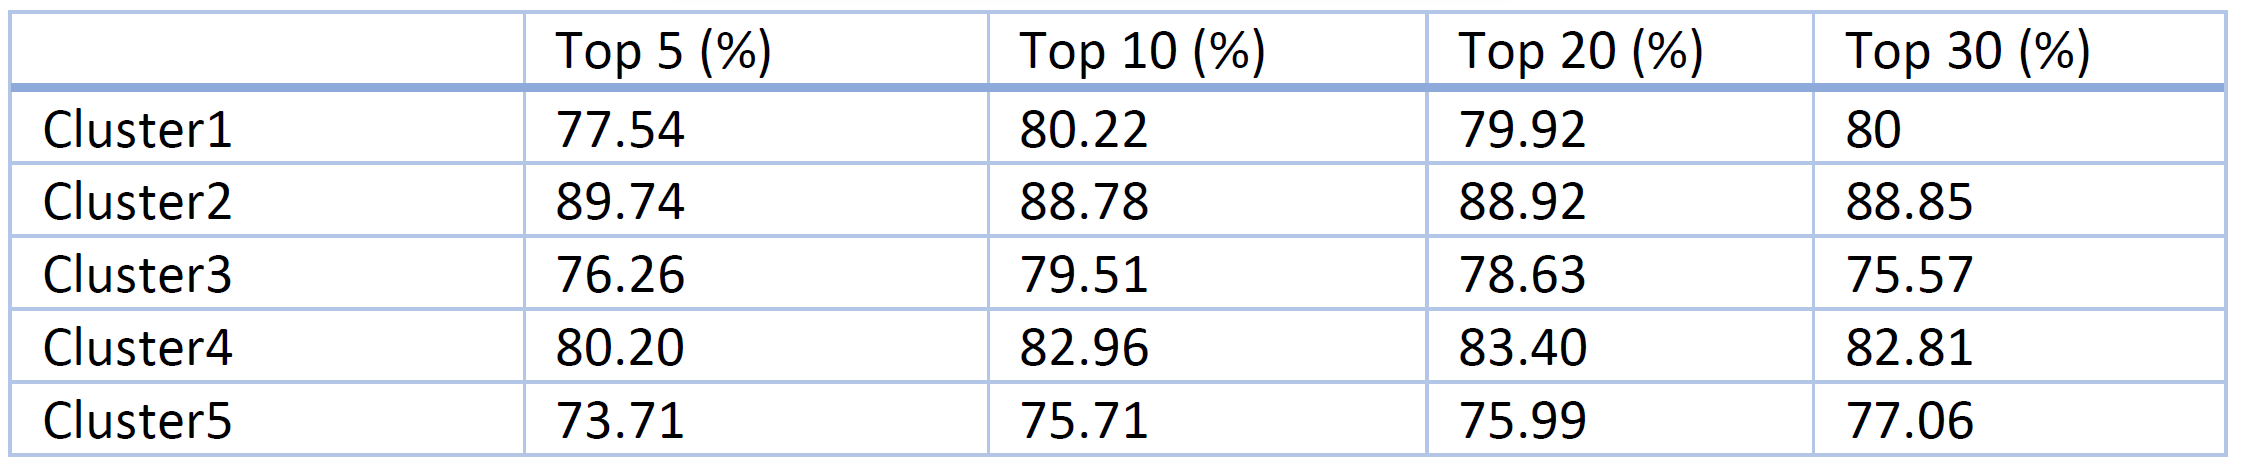

# Summary and Conclusion

In this project, we analyzed the given online news data set and was able to observe some interesting patterns that good articles do have in common. We initially carried out a subjective analysis which was based on our intuition and because we understand it is easily possible for human intuition to be biased or crowded from experience, and use a quantitative analysis to confirm our initial hypothesis by doing univariate and bivariate analysis using scatter plot, boxplot, and bar plot of each feature with the shares feature.

Two main popularity class was considered for the popularity prediction. Un-supervised learning approach was implemented for transforming the data to a 2-dimensional data that is feed to a K-means clustering.

Clustering of the article idea was the major novelty in this project, it allowed us to be able to group similar articles together and their by deploy machine learning models on those clusters as compared to using the models on the whole dataset an effort that was worth it. Generally, without the clustering the best result from other similar works was around 68% using random forest, but by leveraging article clustering we were able to achieve a 75% accuracy and this result can even be better if we consider increasing the number of clusters used and also the feature space.

The same clustering ideology was implemented in the data channel prediction task, which gave us a maximum accuracy of 89% possible as compared to only 82% without clustering. From the insight analysis carried out on the dataset, the following are some of the things we recommend improving the popularity of an article:
- The number of words in the article should be less than 1500 words. The lesser the better.
- Article title shouldn’t be too long or too short. 6 – 17 words is the ideal number of words to have for titles.
- Articles should have good amount of images. Between 1 – 40 images is great.
- Also having a couple of videos is also nice for article popularity, but not too much. The higher the lower the odds.
- Easy to read words helps to improve article popularity.
- The number of keywords in the metadata really influences the shares to a margin. The higher the value the better the shares chances. A value upward of 5 is recommend.
- Articles referencing popular articles have a higher chance of improving their own popularity.
- Increase the number of popular unique words in the article to increase the chances of having better popularity.
- Avoid the use of longer words in the articles.
- Best popular articles are usually posted on Mondays and Wednesday (and a bit of Tuesdays). Sundays and Saturdays (Weekends generally) are the worsts days to publish an article. 
- Articles that talks about current trending tends to have higher popularity.
- Increase the amount of subjectivity in the title and content. 
- The "Business" and "Entertainment" channel are great for the best popularity. Coming in third position will be the "World" and/or "Tech" channels.